# Moving Average Anomaly Detection

Convolution is a mathematical operation that is performed on two functions to produce a third function. Mathematically, it could be described as the integral of the product of two functions, after one is reversed and shifted: $f*g(t)$ = $\int_{-\infty}^{\infty} f(T)*g(t-T) dT$, where f(T) is an input function containing the quantity of interest (e.g. the water pressure). g(t —T) is the weighting function shifted by an amount t. This way as t changes, different weights are assigned to the input function f(T). In our case, f(T) represents the water pressure at time T.  g(t —T) is the moving average kernel. 

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime
from itertools import izip, count
from numpy import linspace, ones, convolve
import collections
from random import randint
%matplotlib inline

# Data

In [2]:
df = pd.read_csv("../data/lcw_chart_data.csv")
df.head()

,eq_init,eq_nr,fault_ts,water_pres,oil_inlet_temp,oil_outlet_temp,anomaly_water,det
0,NS,3658,2018-02-19T01:00:00.000-05:00,51.7660,158.8600,NaN,0,0
1,NS,3658,2018-02-26T17:00:00.000-05:00,52.8745,161.9640,NaN,0,0
2,NS,3658,2018-02-26T18:00:00.000-05:00,53.4560,162.4180,NaN,0,0
3,NS,3658,2018-02-26T19:00:00.000-05:00,56.7750,164.0015,NaN,0,0
4,NS,3658,2018-02-26T20:00:00.000-05:00,54.0230,167.2870,NaN,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107464 entries, 0 to 107463
Data columns (total 8 columns):
eq_init            107464 non-null object
eq_nr              107464 non-null int64
fault_ts           107464 non-null object
water_pres         107464 non-null float64
oil_inlet_temp     107464 non-null float64
oil_outlet_temp    102167 non-null float64
anomaly_water      107464 non-null int64
det                107464 non-null int64
dtypes: float64(3), int64(3), object(2)
memory usage: 6.6+ MB


In [4]:
df.describe()

,eq_nr,water_pres,oil_inlet_temp,oil_outlet_temp,anomaly_water,det
count,107464.000000,107464.000000,107464.000000,102167.000000,107464.000000,107464.000000
mean,6730.855245,49.096098,179.738410,-34011.437391,0.021952,0.009194
std,1708.703232,9.303578,9.759001,55301.681324,0.146526,0.095443
min,3600.000000,0.045000,136.759000,-123456.000000,0.000000,0.000000
25%,4128.000000,42.308000,174.258000,-123456.000000,0.000000,0.000000
50%,7598.000000,50.007000,178.632000,185.551000,0.000000,0.000000
75%,7718.000000,55.392250,183.713000,193.824500,0.000000,0.000000
max,8184.000000,88.525500,240.279500,242.633500,1.000000,1.000000


In [5]:
def change_ts(ts):
    """ 
    Modify the Timestamp in the format 'Y-m-d H:M:S'
    Args: 
    -----
            ts (String): Timestamp
   
    
    Returns:
    --------
            New timestamp in the required format
    """
    date,time = ts.split('T')
    time = time.split('.')[0]
    new_ts = date + ' ' + time
    return new_ts

In [6]:
df['fault_ts'] = df['fault_ts'].apply(change_ts)
df['fault_ts'] = pd.to_datetime(df['fault_ts'], format='%Y-%m-%d %H:%M:%S')

In [7]:
df.head()

,eq_init,eq_nr,fault_ts,water_pres,oil_inlet_temp,oil_outlet_temp,anomaly_water,det
0,NS,3658,2018-02-19 01:00:00,51.7660,158.8600,NaN,0,0
1,NS,3658,2018-02-26 17:00:00,52.8745,161.9640,NaN,0,0
2,NS,3658,2018-02-26 18:00:00,53.4560,162.4180,NaN,0,0
3,NS,3658,2018-02-26 19:00:00,56.7750,164.0015,NaN,0,0
4,NS,3658,2018-02-26 20:00:00,54.0230,167.2870,NaN,0,0


## Exploratory Data Analysis

In [8]:
# Select a single Locomotive
df = df[df['eq_nr'] == 3624]
df.head()

,eq_init,eq_nr,fault_ts,water_pres,oil_inlet_temp,oil_outlet_temp,anomaly_water,det
78158,NS,3624,2017-11-01 12:00:00,45.913,159.611,NaN,0,0
78159,NS,3624,2017-11-01 21:00:00,48.885,160.459,NaN,0,0
78160,NS,3624,2017-11-03 07:00:00,45.676,158.899,NaN,0,0
78161,NS,3624,2017-11-04 01:00:00,50.797,168.793,NaN,0,0
78162,NS,3624,2017-11-08 20:00:00,47.076,156.408,NaN,0,0


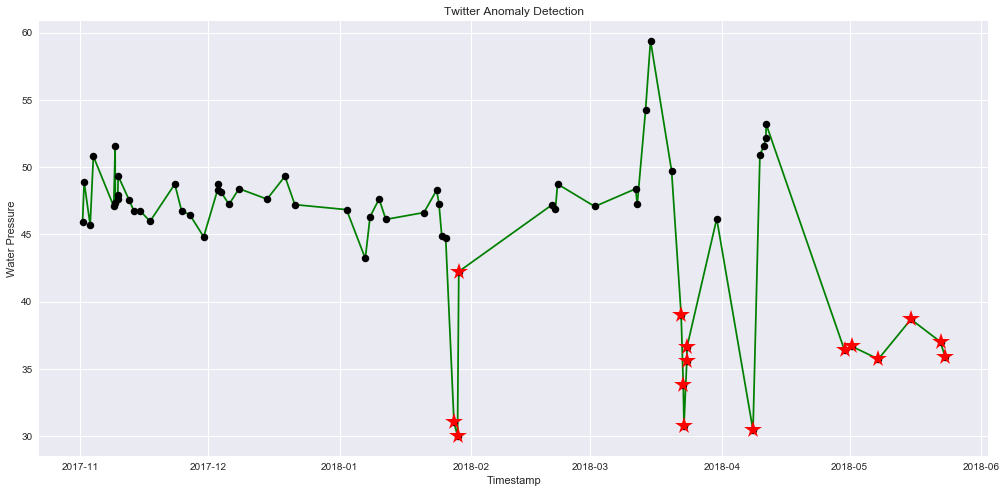

In [21]:
# Plot
plt.figure(figsize = (17,8))
plt.title('Twitter Anomaly Detection')
plt.xlabel('Timestamp')
plt.ylabel('Water Pressure')
x = df['fault_ts']
y = df['water_pres']
anomalies = df[df['anomaly_water'] == 1]
plt.plot(x, y, color = 'green')
plt.plot_date(x, y, "k.", markersize = 15)
plt.plot_date(anomalies['fault_ts'], anomalies['water_pres'], "r*", markersize=18)

## Moving Average Using Discrete Linear Convolution

In [10]:
def moving_average(data, window_size):
    """ Calculate the moving average applying the convolution operation
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution
    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


In [11]:
def find_anomalies(y, window_size, sigma):
    """ Create a dictionary of anomalies using stationary standard deviation
    Args:
    -----
            y (pandas.Series): independent variable
            window_size (int): rolling window size
            sigma (int): value for standard deviation

    Returns:
    --------
            a dictionary that contains the points identified as anomalies
    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [12]:
def find_anomalies_rolling_std(y, window_size, sigma):
    """ Create a dictionary of anomalies anamolies using rolling standard deviation
    Args:
    -----
            y (pandas.Series): independent variable
            window_size (int): rolling window size
            sigma (int): value for standard deviation

    Returns:
    --------
            a dict containing the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [13]:
# Parameters
window_size = 10
sigma_value = 1.2
applying_rolling_std = True

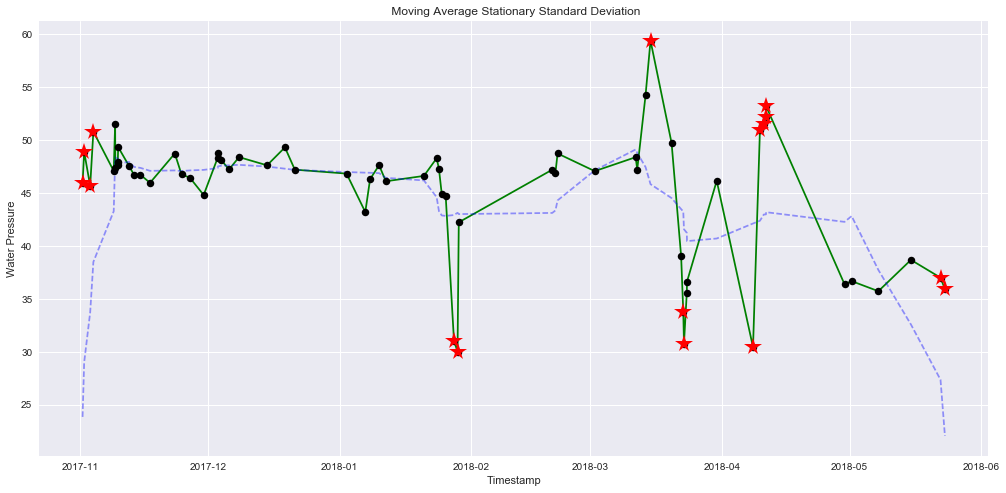

In [14]:
# Plot 
plt.figure(figsize = (17, 8))
plt.plot(x, y, color = 'green')
y_av = moving_average(y, window_size)
plt.plot(x, y_av, linestyle='dashed', color='blue', alpha = 0.4)
plt.plot_date(x, y, "k.", markersize = 15)
plt.title(' Moving Average Stationary Standard Deviation')
plt.xlabel('Timestamp')
plt.ylabel('Water Pressure')

events = find_anomalies(y, window_size=window_size, sigma=sigma_value)

x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float, count=len(events['anomalies_dict']))

anomalies = x.reset_index(drop = True)
plt.plot_date(anomalies[x_anomaly], y_anomaly, "r*", markersize=18)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()


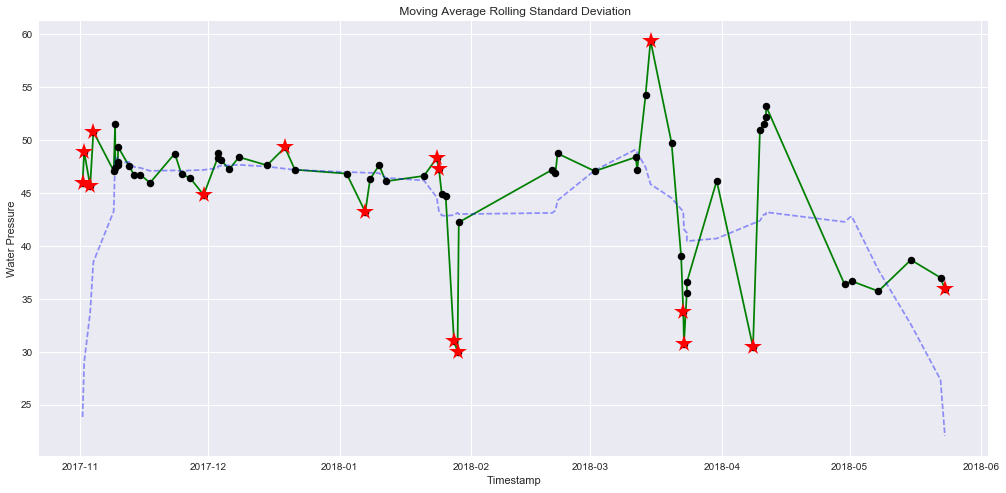

In [15]:
# Plot 
plt.figure(figsize = (17, 8))
plt.plot(x, y, color = 'green')
y_av = moving_average(y, window_size)
plt.plot(x, y_av, linestyle='dashed', color='blue', alpha = 0.4)
plt.plot_date(x, y, "k.", markersize = 15)
plt.title(' Moving Average Rolling Standard Deviation')
plt.xlabel('Timestamp')
plt.ylabel('Water Pressure')

events = find_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)

x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float, count=len(events['anomalies_dict']))

anomalies = x.reset_index(drop = True)
plt.plot_date(anomalies[x_anomaly], y_anomaly, "r*", markersize=18)